# Object recognition using googlenet V2 on Intel Compute Stick.
## Codes works on both Neural Compute Stick 2 and Movidius compute Stick-1

# Imports: Note source need to be initialized according to the installed folder of the OpenVINO

In [29]:
# # Ensure that the OpenVINO environment is initialized
# source /opt/intel/computer_vision_sdk/bin/setupvars.sh

import sys
import os
import logging as log
import cv2
import numpy as np
from time import time
from openvino.inference_engine import IENetwork, IEPlugin

# Points to the downloaded and optimized model.
## Do the setup first

In [30]:
## converting TF model:
# mo_tf.py --input_model mobilenet_v1_1.0_224_frozen.pb  --output MobilenetV1/Predictions/Reshape_1 --input input  --batch 1  --data_type FP16

model_xml = '/home/nesl/Heliot/github/Heliot/computation/Tests/data/mobilenet_v1_1.0_224/mobilenet_v1_1.0_224_frozen.xml'

model_bin = '/home/nesl/Heliot/github/Heliot/computation/Tests/data/mobilenet_v1_1.0_224/mobilenet_v1_1.0_224_frozen.bin'

# Device type is: MYRIAD

In [31]:
plugin = IEPlugin(device='MYRIAD', plugin_dirs=None)

# Net and input, ouput blobs

In [32]:
net = IENetwork.from_ir(model=model_xml, weights=model_bin)

input_blob = next(iter(net.inputs))
out_blob = next(iter(net.outputs))

# Only one image as input
net.batch_size =1

In [33]:
def preprocess_input(x):
    x /= 255.0
    x -= 0.5
    x *= 2.0
    return x

# Resizing the image based on network input layer

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image is resized from (636, 1024) to (224, 224)


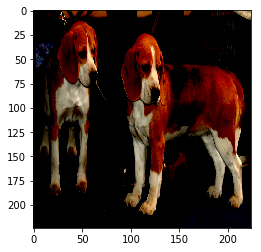

Batch size is 1


In [45]:
# Read and pre-process input images
n, c, h, w = net.inputs[input_blob].shape
images = np.ndarray(shape=(n, c, h, w))

#image = cv2.imread('data/Tiger.jpg')
image = cv2.imread('data/image1.jpg')



if image.shape[:-1] != (h, w):
    print("Image is resized from {} to {}".format(image.shape[:-1], (h, w)))
    image = cv2.resize(image, (w, h))

image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

image = image.astype(float)

image = preprocess_input(image)

    
from matplotlib import pyplot as plt
plt.imshow(image)
plt.show()
    
image = image.transpose((2, 0, 1))  # Change data layout from HWC to CHW
images[0] = image
print("Batch size is {}".format(n))



# Putting the model on the device Running the inference

In [35]:
t0 = time()

# Loading model to the plugin
print("Loading model to the plugin")
exec_net = plugin.load(network=net)

res = exec_net.infer(inputs={input_blob: images})
t1 = time()

print('Total Time taken transfer model and to run Inference is:', t1-t0)

#del net

Loading model to the plugin
Total Time taken transfer model and to run Inference is: 3.2695958614349365


In [50]:
t0 = time()
res = exec_net.infer(inputs={input_blob: images})
t1 = time()

print('Time to run Inference is:', t1-t0)

Time to run Inference is: 0.0465998649597168


In [46]:
t0 = time()
res = exec_net.infer()
t1 = time()

print('Time to run Inference is:', t1-t0)

Time to run Inference is: 0.04665780067443848


# Using labels

In [47]:
#Load categories
categories = []
with open('../data/' + 'categories.txt', 'r') as f:
    for line in f:
        cat = line.split('\n')[0]
        if cat != 'classes':
            categories.append(cat)
    f.close()
    print('Number of categories:', len(categories))

Number of categories: 1001


# Processing the results

In [51]:
# Processing output blob
print("Processing output blob")
res2 = res[out_blob]
top_number = 5

#labels_map =None

for i, probs in enumerate(res2):
    probs = np.squeeze(probs)
    
    top_ind = np.argsort(probs)[-top_number:][::-1]
    
    for id in top_ind:
        det_label = categories[id]  if categories else "#{}".format(id)
        print("{:.7f} label {}".format(probs[id], det_label))
    print("\n")

Processing output blob
0.4587402 label beagle
0.3278809 label English foxhound
0.0778809 label Walker hound, Walker foxhound
0.0646362 label Saint Bernard, St Bernard
0.0265045 label basenji




# Cleanup

In [28]:
del exec_net
del plugin